In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
block_path = '/home/AD/tsheehan/data/Pen01_Lft_AP750_ML1750__Site01_Z1100__B952_cat_P01_S01_1'
from ephys import core
from ephys import clust
from ephys import events
from ephys import rasters
import os
import scipy as sp
import scipy.io.wavfile as wf
import scipy.signal as signal
#import pywt # wavelet toolbox

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
# want to get STA and STC for example dataset
# load response (neurons), stimulus (wav files to spectrograms)
clusters = core.load_clusters(block_path) # pandas - DataFrame
neurons = (
    clusters[clusters.quality.isin(['Good'])]
    .sort_values(['quality','cluster'],ascending=False)
    .reset_index()
)
trials = events.load_trials(block_path)
stim_labels = list(set(trials.stimulus))
spikes = core.load_spikes(block_path)


In [4]:
fs = 44100
stim_labels[0]
stim_loc = block_path + '/stims'
files = os.listdir(stim_loc)
songs = []
spects = []
freqs = []
times = []
noverlap = 512
nperseg = 1024

for i in range(len(stim_labels)):
    this_label = stim_labels[i] +'.wav'
    my_song = [x for x in files if x in this_label]
    if my_song:
        this_song = wf.read(stim_loc + '/' + my_song[0])
        songs.append((this_song[1]))    
    
    my_spect = signal.spectrogram(songs[i],fs =fs, nperseg = nperseg,noverlap = noverlap)
    spects.append(my_spect[2])
    freqs.append(my_spect[0])
    times.append(my_spect[1])
    
    print(len(this_song[1]))

2892045
2961304
2674358
2400000
2400000


In [5]:
# stim_ind= 0
# start_time = trials[trials.stimulus==stim_labels[stim_ind]].time_samples
# end_time = trials[trials.stimulus==stim_labels[stim_ind]].stimulus_end

# fs = core.load_fs(block_path)

In [6]:
# labels = trials['stimulus']
# neuron_ind = 2
# my_cluster = neurons['cluster'][neuron_ind]
# my_spikes = spikes[spikes['cluster']==my_cluster]
# my_times = my_spikes['time_samples']
# trials.head()
# len_all = trials['stimulus_end'].values[-1]
# my_times = my_times[my_times<=len_all]




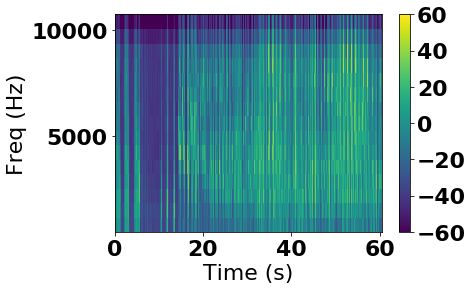

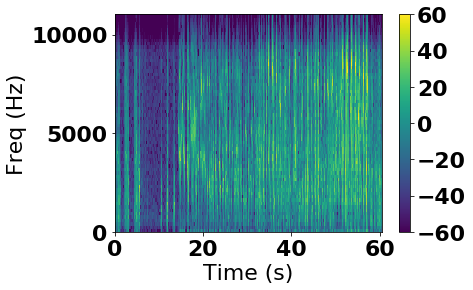

In [180]:
import get_STA as get_STA_p
reload(get_STA_p)
stim_use = 2
neuron_ind = 12
this_label = stim_labels[stim_use]
these_trials = trials[trials['stimulus']==this_label]
this_st = these_trials['time_samples'].values
this_end = these_trials['stimulus_end'].values
dd = this_end-this_st


my_cluster = neurons['cluster'][neuron_ind]
my_spikes = spikes[spikes['cluster']==my_cluster]
my_times = my_spikes['time_samples']

#get_STA_p.get_STA_from_points(my_times,this_end,dd[0],songs[stim_use],50)
#tmp  = get_STA_p.get_STA_mult_song(my_times,songs,trials)
#get_STA_p.plot_STA_mult_song(my_times,songs,trials,[],1)
#songs[1]
#neurons
#get_STA_p.plot_STA_mult_neuron(neurons,spikes,songs,trials,40)
s_view = 2
c_lim = (-60,60)
#get_STA_p.visualize_reduced_spectrogram(songs[s_view],c_lim)
#get_STA_p.visualize_full_spectrogram(songs[s_view],c_lim)
#ratio = get_STA_p.get_ds_rate(songs)
spk_times = my_spikes['time_samples'].values


In [171]:
# def song_mask(trials):
#     songs = 
song_names = list(set(trials['stimulus']))
song_mask, song_ramp = get_STA_p.get_song_mask(trials,ratio)
#plt.hist(tmp)

#plt.hist(song_mask,(np.linspace(0,4.5,10)));
#print(ratio)
#song_mask
#tmp = np.arange(0,1200,1200)

STA,f = get_STA_p.get_sta(spk_times,songs,song_mask,song_ramp,20)


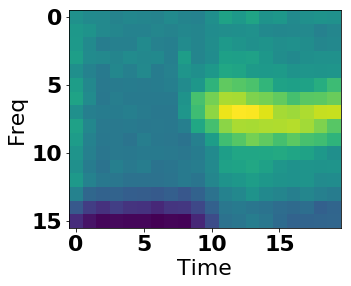

In [183]:
mSTA = np.mean(STA,0)
#t = np.arange(20*20,0,-20)


plt.imshow(mSTA)
plt.xlabel('Time')
plt.ylabel('Freq')
#print(np.shape(mSTA))
#np.any([])
#help('enumerate')

In [134]:
# test spectrogram and lpf
from scipy.signal import decimate
song = songs[0]

# def butter_lowpass(cutoff, fs, order=5):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

# # filtering 
# fs = 44100
# cutoff = 24000
# order = 2

# b, a = butter_lowpass(cutoff, fs, order)
fs = float(44100)
fs_new = 24000


song_d = decimate(song,2,zero_phase = True)
fs_new = 44100/2
f, t, ss = signal.spectrogram(song_d,fs = fs_new, nperseg = 128,noverlap = 64,nfft = 128)
# remove DC component
f = f[1:]
ss = ss[1:,:]

# convert to decibles, then average rows
ss_D = 10*np.log10(ss)

def windowed_avg_rows(dat,n_per_win=4):
    n_rows = np.shape(dat)[0]
    n_col = np.shape(dat)[1]
    
    st_points = np.arange(0,n_rows,n_per_win)
    n_rows_new = len(st_points)
    windowed_avg = np.zeros((n_rows_new, n_col))
                          
    for i in range(n_rows_new):
        these_vals = dat[st_points[i]:st_points[i]+n_per_win,:]
        windowed_avg[i,:] = np.mean(these_vals,0)
    return windowed_avg
                   
def windowed_avg_col(dat,t,ms_per_win = 20):
    t_per_win = ms_per_win/1000
    val_per_win = int(round(t_per_win/period))
    n_row = np.shape(dat)[0]
    n_col = np.shape(dat)[1]
    st_points = np.arange(0,n_col-val_per_win+1,val_per_win)
    n_pts = len(st_points)
    windowed_avg = np.zeros((n_row, n_pts))
    
    for i in range(n_pts):
        these_vals = dat[:,st_points[i]:st_points[i]+val_per_win]
        windowed_avg[:,i] = np.mean(these_vals,1)
    t_new = t[st_points]
    return windowed_avg, t_new

def reduced_spectrogram(song,fs=44100):
    song_d = decimate(song,2,zero_phase = True)
    fs_new = fs/2
    nperseg = 128
    overlap = 64
    nfft = 128
    f, t, ss = signal.spectrogram(song_d,fs = fs_new, nperseg = 128,noverlap = 64,nfft = 128)
    # remove DC component
    f = f[1:]
    ss = ss[1:,:]
    ss_D = 10*np.log10(ss)
    
    ss_Df = windowed_avg_rows(ss_D)
    ss_Dft, t_new = windowed_avg_col(ss_Df,t)
    return ss_Dft

    
    

#dat, t_new = windowed_avg_col(tmp,t)



In [133]:
np.shape(dat)
t_new[0:5]

array([ 0.00290249,  0.02321995,  0.04353741,  0.06385488,  0.08417234])